# Cyberbullying Filter

In [2]:
import pandas as pd
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import string
import nltk
from nltk import word_tokenize          
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import emoji
import numpy as np

## Preparing The Data

_data.csv_ is the labelled cyberbully data from http://research.cs.wisc.edu/bullying/data.html

_tweets.csv_ is the raw tweet data from twitter.com.

In [4]:
tweet = pd.read_csv("tweet.csv")
data  = pd.read_csv("data.csv")
print("The number of tweets in tweet.csv is ", tweet.tweet_id.nunique())
print("The number of tweets in data.csv is ", data.tweet_id.nunique())

allTweets = pd.merge(tweet, data, on='tweet_id')
print("The number of merged tweets (training set) is ", allTweets.tweet_id.nunique())

bullyTweets = allTweets.loc[allTweets["flag"] == "y"]
noBullyTweets = allTweets.loc[allTweets["flag"] == "n"]
print("The number of bully flag tweets (flag == y) is ", bullyTweets.tweet_id.nunique())
print("The number of non bullying tweets (flag == n) is ", noBullyTweets.tweet_id.nunique())

The number of tweets in tweet.csv is  2729
The number of tweets in data.csv is  7298
The number of merged tweets (training set) is  2729
The number of bully flag tweets (flag == y) is  1109
The number of non bullying tweets (flag == n) is  1622


In [222]:
noBullyTweets

,tweet_id,tweet,lang,user_id,flag,type,c1,c2,c3,c4
1,100254756332769280,"Paula, Kiersten and LJ's song about bullying. ...",en,108461242,n,NaN,NaN,NaN,NaN,NaN
4,106150056868061184,"If I'm not happy with my classes this week, I'...",en,61120235,n,NaN,NaN,NaN,NaN,NaN
6,104199536133668864,@ninjacodemonkey totally. on one hand the ret...,en,1380901,n,NaN,NaN,NaN,NaN,NaN
7,103471384973418497,"@lucy_robbo yes on thur, she said she might, w...",en,219025244,n,NaN,NaN,NaN,NaN,NaN
8,101884602586636288,theres going to be bullys and ignorant people ...,en,53301091,n,NaN,NaN,NaN,NaN,NaN
11,102779484725448704,The Bully at School Goes High Tech – Part 1: \...,en,297557032,n,NaN,NaN,NaN,NaN,NaN
12,104826899435491328,Follow-Up to ' Signs Your Child Might Be Getti...,en,94912172,n,NaN,NaN,NaN,NaN,NaN
13,100689407677440000,WED at 8pm on #LETITBEKNOWNLIVERADIO our Discu...,en,181218735,n,NaN,NaN,NaN,NaN,NaN
15,103502694634889216,@BillyBlancO_ @DjLBully nigga used to be a rea...,en,24170927,n,NaN,NaN,NaN,NaN,NaN
16,104295456787533824,Georgetown got there asses kicked but china.. ...,en,233093898,n,NaN,NaN,NaN,NaN,NaN


## Dictionary Creation
Creates a function that uses  alist and empty dictionary to return a dictionary of all the words and their frequencies from the tweets, sorted by their frequencies.

In [413]:
# supporting functions

def tokenize(text):
    tokens = [i.strip() for i in text if i not in string.punctuation if i not in emoji.UNICODE_EMOJI]
    return "".join(tokens)

stopwordSet = set(stopwords.words("english"))
def word_filter(word):
    # strip
    word = word.strip().lower()
    word = tokenize(word.strip(string.punctuation))
    if word == "":
        return False, None
    # get rid of mentions (@USERNAME)
    if word[0] == "@":
        return False, None
    
    # get rid of stopwords
    elif (word in stopwordSet):
        return False, None
    
    # get rid of emojis
    elif word in emoji.UNICODE_EMOJI:
        return False, None
    return True, word

word_filter("'it'")

(False, None)

~~~

In [414]:
def dictionary_creation(tweetLst, bullyVocab):
    for tweet in tweetLst:
        for word in tweet.split():
            flag, resultWord = word_filter(word)

            if flag:
                if(resultWord == "it"):
                    print(flag, resultWord)
                # check if in bullyVocab
                if resultWord in bullyVocab:
                    bullyVocab[resultWord] += 1
                else:
                    bullyVocab[resultWord] = 1
    bullyVocab = sorted(bullyVocab.items(), key = lambda kv: kv[1], reverse = True)
    return bullyVocab

In [415]:
def bar_graph(bullyVocab, number):
    # create a bar graph of the bullyVocab data
    words = [i[0] for i in bullyVocab if not i[0] == ""]
    topNWords = words[:number]

    y_pos = np.arange(len(topNWords))
    frequency = [i[1] for i in bullyVocab if not i[0] == ""]
    topNFrequency = frequency[:number]
    
    plt.figure(figsize = (15, 7))

    plt.bar(y_pos, topNFrequency, align = 'center')
    plt.xticks(y_pos, topNWords)
    plt.xticks(rotation = 50)
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.show()

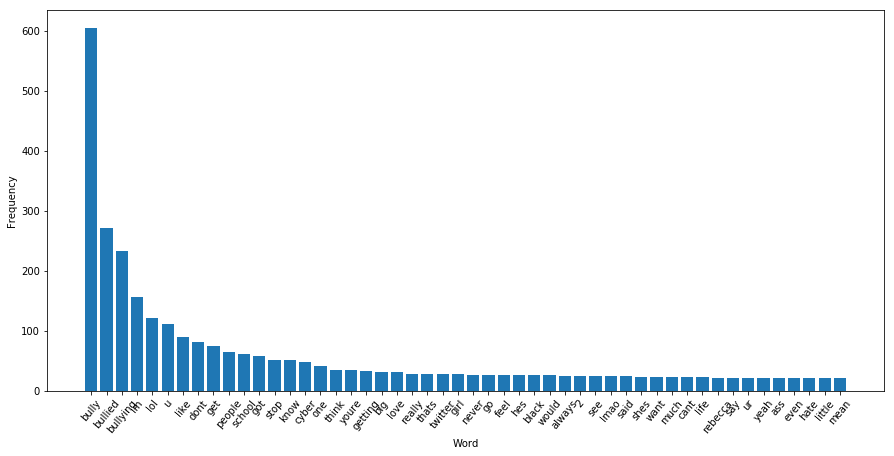

In [417]:
bullyTweetLst = bullyTweets["tweet"].tolist()

bullyVocab = {}
dictionary_creation(bullyTweetLst, bullyVocab)

# sort the dictionary by the words with the highest frequency                
bullyVocab = sorted(bullyVocab.items(), key = lambda kv: kv[1], reverse = True)

bar_graph(bullyVocab, 50)

## Word Clouds

Generating wordclouds based on frequencies!

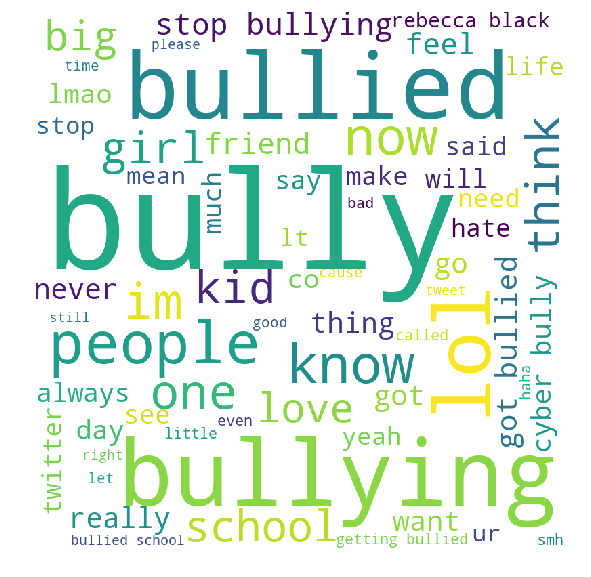

In [421]:
comment_words = " "
comment_words2 = " "

def generate_wordcloud(tweets, comment_words, fontsize):
    for val in tweets.tweet:
        val = str(val)
        words = val.split()
        for i in range(len(words)):
            words[i] = words[i].lower()
            
        for word in words:
            comment_words = comment_words + word + " "
            
    # actual cloud
    wordcloud = WordCloud(width = 800, height = 800, background_color = 'white',
                          stopwords = set(STOPWORDS), min_font_size = fontsize).generate(comment_words)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0.5)
    plt.show()

generate_wordcloud(bullyTweets, comment_words, 20)

# generate_wordcloud(noBullyTweets, comment_words2, 20)

In [420]:
def img_wordcloud(tweets, image, comment_words):
    mask = np.array(open(image))
    wordcloud = Wordcloud(stopwords = stopwords, background_color = "white", mode = "RGBA",
                         max_words = 1000, mask = mask).generate(tweets)
    
    # colors
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize = [8, 8])
    plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation = "bilinear")
    plt.axis("off")
    
    plt.show()
    
#img_wordcloud(bullyTweets, "![image.png](attachment:image.png)", comment_words)
